In [13]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
data = pd.read_csv('cleaned_online_retail_data.csv')

# Ensure 'InvoiceDate' is parsed as a datetime object
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Filter necessary columns
basket_data = data[['Invoice', 'Description']]

# Remove canceled transactions (if applicable)
basket_data = basket_data[~basket_data['Invoice'].str.contains('C', na=False)]

# Create a basket format (one-hot encoding for products)
basket = basket_data.groupby(['Invoice', 'Description']).size().unstack(fill_value=0).astype(bool)
print(basket.head())


Description    DOORMAT UNION JACK GUNS AND ROSES   3 STRIPEY MICE FELTCRAFT  \
Invoice                                                                       
489434                                     False                      False   
489435                                     False                      False   
489436                                     False                      False   
489437                                     False                      False   
489438                                     False                      False   

Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
Invoice                                                                       
489434                                False                           False   
489435                                False                           False   
489436                                False                           False   
489437                                False        

In [7]:
# Apply Apriori algorithm
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# View the results
print(frequent_itemsets.head())

    support                               itemsets
0  0.012765               (10 COLOUR SPACEBOY PEN)
1  0.013901        (12 PENCIL SMALL TUBE WOODLAND)
2  0.012414  (12 PENCILS SMALL TUBE RED RETROSPOT)
3  0.018499          (12 PENCILS SMALL TUBE SKULL)
4  0.013171          (12 PENCILS TALL TUBE SKULLS)


In [8]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Filter rules for actionable insights
rules = rules.sort_values(by="lift", ascending=False)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


                         antecedents                      consequents  \
295  (POPPY'S PLAYHOUSE LIVINGROOM )     (POPPY'S PLAYHOUSE BEDROOM )   
294     (POPPY'S PLAYHOUSE BEDROOM )  (POPPY'S PLAYHOUSE LIVINGROOM )   
297  (POPPY'S PLAYHOUSE LIVINGROOM )      (POPPY'S PLAYHOUSE KITCHEN)   
296      (POPPY'S PLAYHOUSE KITCHEN)  (POPPY'S PLAYHOUSE LIVINGROOM )   
292      (POPPY'S PLAYHOUSE KITCHEN)     (POPPY'S PLAYHOUSE BEDROOM )   

      support  confidence       lift  
295  0.010331    0.830435  55.225407  
294  0.010331    0.687050  55.225407  
297  0.011034    0.886957  53.238989  
296  0.011034    0.662338  53.238989  
292  0.012765    0.766234  50.955924  


In [9]:
# Select high-lift rules
bundling_candidates = rules[rules['lift'] > 1.2]

# Print top recommendations
for _, row in bundling_candidates.head().iterrows():
    print(f"Bundle: {set(row['antecedents'])} with {set(row['consequents'])}")
    print(f"Lift: {row['lift']:.2f}, Confidence: {row['confidence']:.2f}")


Bundle: {"POPPY'S PLAYHOUSE LIVINGROOM "} with {"POPPY'S PLAYHOUSE BEDROOM "}
Lift: 55.23, Confidence: 0.83
Bundle: {"POPPY'S PLAYHOUSE BEDROOM "} with {"POPPY'S PLAYHOUSE LIVINGROOM "}
Lift: 55.23, Confidence: 0.69
Bundle: {"POPPY'S PLAYHOUSE LIVINGROOM "} with {"POPPY'S PLAYHOUSE KITCHEN"}
Lift: 53.24, Confidence: 0.89
Bundle: {"POPPY'S PLAYHOUSE KITCHEN"} with {"POPPY'S PLAYHOUSE LIVINGROOM "}
Lift: 53.24, Confidence: 0.66
Bundle: {"POPPY'S PLAYHOUSE KITCHEN"} with {"POPPY'S PLAYHOUSE BEDROOM "}
Lift: 50.96, Confidence: 0.77


In [16]:
# Filter by minimum lift (e.g., lift > 1.5) and minimum confidence (e.g., confidence > 0.6)
filtered_rules = rules[(rules['lift'] > 1.5) & (rules['confidence'] > 0.6)]

# Sort by lift and take the top 10 strongest associations
top_filtered_rules = filtered_rules.sort_values(by='lift', ascending=False).head(10)

# Display top filtered associations
print(top_filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


                         antecedents                      consequents  \
295  (POPPY'S PLAYHOUSE LIVINGROOM )     (POPPY'S PLAYHOUSE BEDROOM )   
294     (POPPY'S PLAYHOUSE BEDROOM )  (POPPY'S PLAYHOUSE LIVINGROOM )   
297  (POPPY'S PLAYHOUSE LIVINGROOM )      (POPPY'S PLAYHOUSE KITCHEN)   
296      (POPPY'S PLAYHOUSE KITCHEN)  (POPPY'S PLAYHOUSE LIVINGROOM )   
292      (POPPY'S PLAYHOUSE KITCHEN)     (POPPY'S PLAYHOUSE BEDROOM )   
293     (POPPY'S PLAYHOUSE BEDROOM )      (POPPY'S PLAYHOUSE KITCHEN)   
313  (SET/6 RED SPOTTY PAPER PLATES)    (SET/6 RED SPOTTY PAPER CUPS)   
312    (SET/6 RED SPOTTY PAPER CUPS)  (SET/6 RED SPOTTY PAPER PLATES)   
183                 (KEY FOB , SHED)           (KEY FOB , BACK DOOR )   
182           (KEY FOB , BACK DOOR )                 (KEY FOB , SHED)   

      support  confidence       lift  
295  0.010331    0.830435  55.225407  
294  0.010331    0.687050  55.225407  
297  0.011034    0.886957  53.238989  
296  0.011034    0.662338  53.238989  
2

C:\Users\ferhe\AppData\Local\Temp\ipykernel_26824\1555428760.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_filtered_rules['lift'],


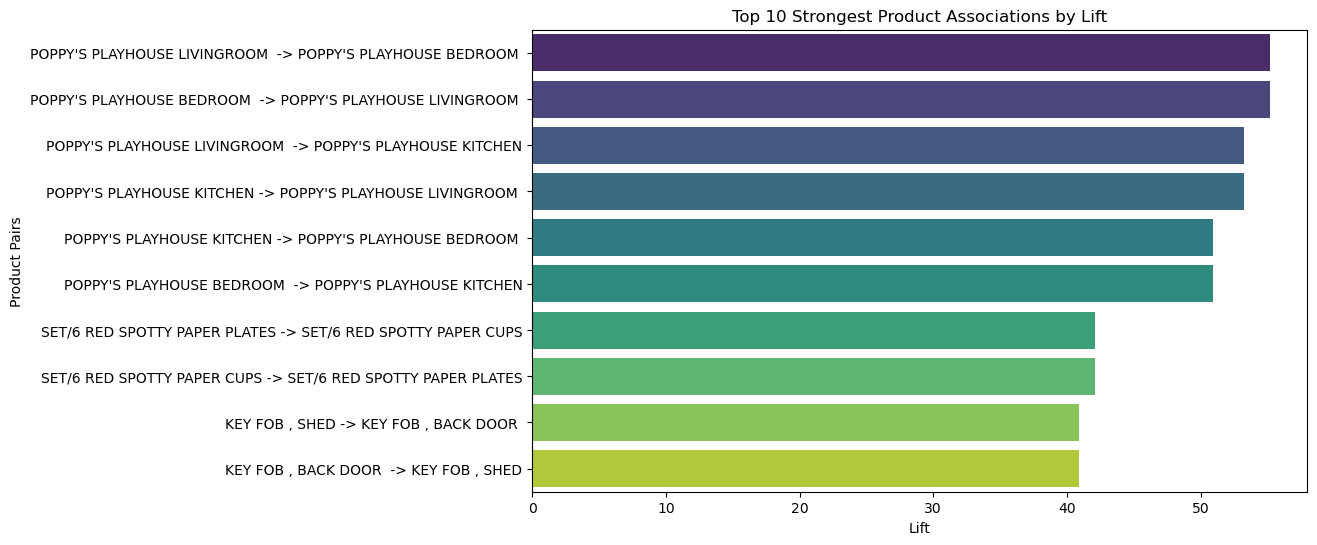

In [17]:
# Plot bar chart of the top 10 strongest associations by lift
plt.figure(figsize=(10, 6))
sns.barplot(x=top_filtered_rules['lift'], 
            y=top_filtered_rules.apply(lambda x: f"{', '.join(x['antecedents'])} -> {', '.join(x['consequents'])}", axis=1),
            palette='viridis')

plt.title('Top 10 Strongest Product Associations by Lift')
plt.xlabel('Lift')
plt.ylabel('Product Pairs')
plt.show()

# Some are duplicates since they represent the same relationship (just flipped)

In [19]:
# Sort antecedents and consequents to ensure consistency
rules['sorted_antecedents'] = rules['antecedents'].apply(lambda x: tuple(sorted(x)))
rules['sorted_consequents'] = rules['consequents'].apply(lambda x: tuple(sorted(x)))

# Create a new column that combines sorted antecedents and consequents
rules['sorted_pair'] = rules.apply(lambda row: tuple(sorted([row['sorted_antecedents'], row['sorted_consequents']])), axis=1)

# Remove duplicates by considering sorted pairs
unique_rules = rules.drop_duplicates(subset='sorted_pair')

# Display the top 10 unique rules
top_10_unique_rules = unique_rules.sort_values(by='lift', ascending=False).head(10)
print(top_10_unique_rules[['sorted_antecedents', 'sorted_consequents', 'support', 'confidence', 'lift']])


                        sorted_antecedents  \
295       (POPPY'S PLAYHOUSE LIVINGROOM ,)   
297       (POPPY'S PLAYHOUSE LIVINGROOM ,)   
292           (POPPY'S PLAYHOUSE KITCHEN,)   
313       (SET/6 RED SPOTTY PAPER PLATES,)   
183                      (KEY FOB , SHED,)   
83    (FELTCRAFT PRINCESS CHARLOTTE DOLL,)   
47       (RED STRIPE CERAMIC DRAWER KNOB,)   
350      (PINK REGENCY TEACUP AND SAUCER,)   
344  (WOODEN STAR CHRISTMAS SCANDINAVIAN,)   
79             (FELTCRAFT CUSHION RABBIT,)   

                                    sorted_consequents   support  confidence  \
295                      (POPPY'S PLAYHOUSE BEDROOM ,)  0.010331    0.830435   
297                       (POPPY'S PLAYHOUSE KITCHEN,)  0.011034    0.886957   
292                      (POPPY'S PLAYHOUSE BEDROOM ,)  0.012765    0.766234   
313                     (SET/6 RED SPOTTY PAPER CUPS,)  0.013225    0.706647   
183                            (KEY FOB , BACK DOOR ,)  0.011251    0.636086   
83           

C:\Users\ferhe\AppData\Local\Temp\ipykernel_26824\211888907.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


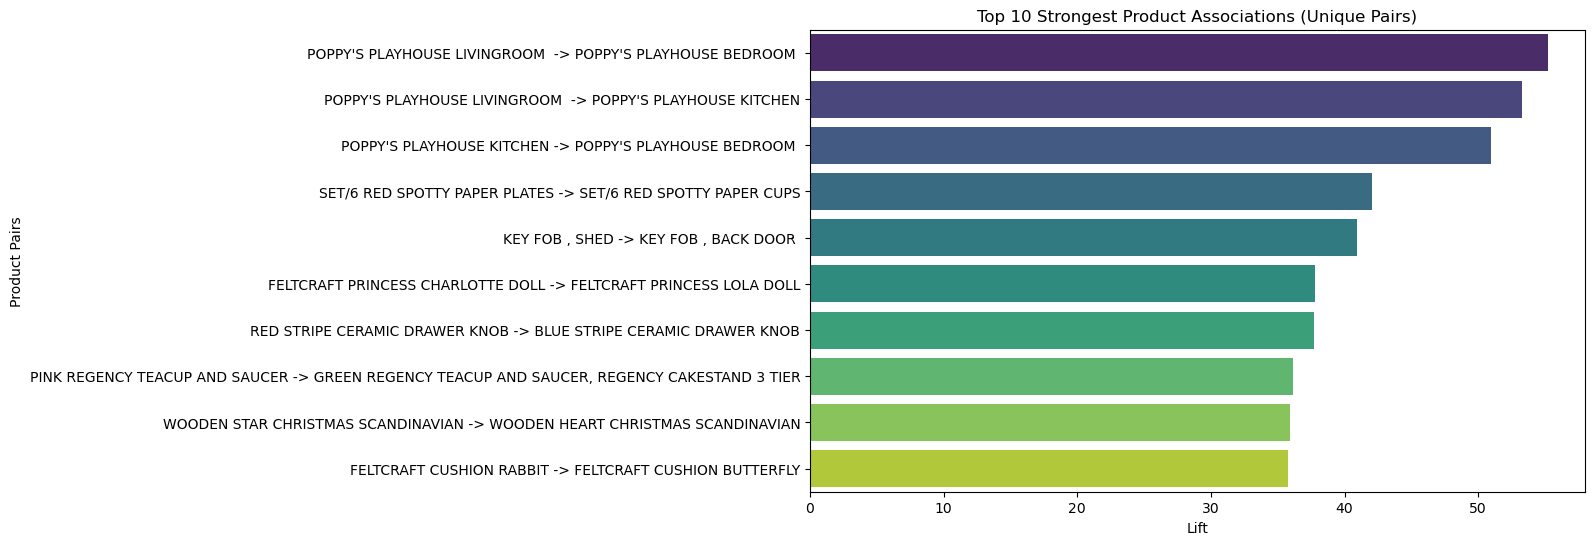

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_unique_rules['lift'],
    y=top_10_unique_rules.apply(lambda x: f"{', '.join(x['sorted_antecedents'])} -> {', '.join(x['sorted_consequents'])}", axis=1),
    palette='viridis'
)
plt.title('Top 10 Strongest Product Associations (Unique Pairs)')
plt.xlabel('Lift')
plt.ylabel('Product Pairs')
plt.show()
